In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import linear_model
import shap

In [6]:
x = pd.read_csv("../data/shops_data.csv")
x.drop(x.columns[0], axis=1, inplace=True)
x.head()

,liczba budynków – suma,liczba budynków - mieszkalnych,liczba mieszkań - mieszkalnych według DataWise,szacowana liczba mieszkańców razem,średnia liczba osób na gospodarstwo domowe,gęstość zaludnienia osób na km2,szacowany średni wiek mieszkańców razem,populacja - procent kobiet,populacja - procent mężczyzn,przykład: 4.13,...,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - miejsca kultu (kościół),odległość w metrach do najbliższego POI (-1 = większa niż 5000 m) - poczta (poczta),odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - rozrywka i kult,odległość w metrach do najbliższego POI (-1 = większe niż 5000 m) - stacja benzynowa (stacja paliw),odległość w metrach do najbliższego punktu POI (-1 = większa niż 5000 m) - suma transportu,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - stacja kolejowa transportu,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - zatrzymuje się transport,odległość w metrach do najbliższego POI (-1 = więcej niż 5000 m) - biuro / administracja publiczna,odległość w metrach do najbliższego POI (-1 = więcej niż 5000 m) - suma zdrowia,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - apteka zdrowia
0,389.0,333.0,879.0,2447.0,3.10,7456.0,43.2,52.80,47.20,4.17,...,50.0,457.0,457.0,1161.0,103.0,2378.0,103.0,1217.0,200.0,420.0
1,215.0,166.0,766.0,1848.0,2.50,6752.0,45.1,55.03,44.97,3.41,...,362.0,77.0,2572.0,242.0,63.0,580.0,63.0,1464.0,0.0,0.0
2,317.0,183.0,2397.0,4702.0,2.19,18884.0,41.0,54.91,45.09,7.04,...,95.0,197.0,358.0,412.0,138.0,1400.0,158.0,406.0,57.0,57.0
3,21.0,7.0,52.0,212.0,2.41,2332.0,34.6,36.32,63.68,5.19,...,751.0,252.0,255.0,472.0,204.0,1287.0,204.0,1168.0,89.0,179.0
4,64.0,33.0,799.0,1900.0,2.41,11243.0,45.4,54.68,45.32,3.11,...,542.0,488.0,294.0,893.0,128.0,2986.0,128.0,2081.0,66.0,66.0


In [8]:
y = pd.read_csv("../data/product2.csv")
y.drop(y.columns[0], axis=1, inplace=True)
y.rename(columns={"0": "sales"}, inplace=True)
y.head()

,sales
0,313.362216
1,339.919920
2,305.546245
3,401.241329
4,333.573685


In [9]:
x_background_dist = x[:100]
x = x[100:]
y = y[100:]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y.values, test_size=0.2, random_state=0)

In [11]:
np.mean(y_test), np.std(y_test)

(np.float64(917.0667920578974), np.float64(92.8544784563367))

In [12]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
np.sqrt(np.mean((lin_regr.predict(X_test) - y_test) ** 2))

np.float64(6.068940163482873)

In [13]:
explainer = shap.Explainer(lin_regr.predict, x_background_dist)
shap_values = explainer(X_test) 

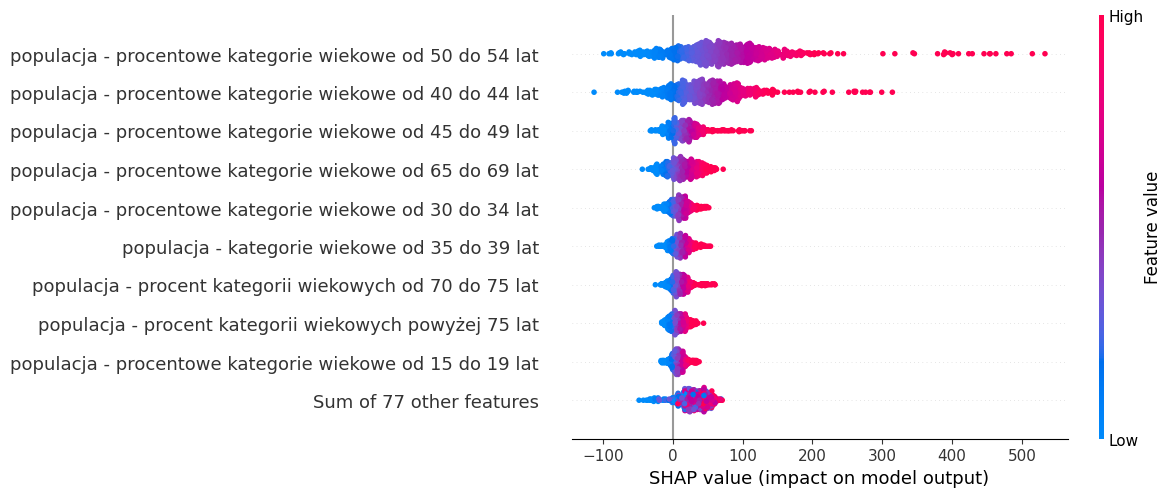

In [14]:
shap.plots.beeswarm(shap_values)

In [15]:
mean_shape_values = shap_values.mean(0).values
feature_importance_by_shapley = dict((zip(X_test.columns, mean_shape_values)))
feature_importance_by_shapley["populacja - procentowe kategorie wiekowe od 40 do 44 lat"], feature_importance_by_shapley["populacja - procentowe kategorie wiekowe od 20 do 24 lat"]

(np.float64(51.36803203625569), np.float64(6.0991011064347935))

In [16]:
feature_importance_by_shapley

{'liczba budynków – suma': np.float64(-0.08992952643920202),
 'liczba budynków - mieszkalnych': np.float64(-0.11425765773674135),
 'liczba mieszkań - mieszkalnych według DataWise': np.float64(-0.06584233230533698),
 'szacowana liczba mieszkańców razem': np.float64(-0.05031906288689121),
 'średnia liczba osób na gospodarstwo domowe': np.float64(-0.024802770803743445),
 'gęstość zaludnienia osób na km2': np.float64(-0.256325613037734),
 'szacowany średni wiek mieszkańców razem': np.float64(0.06564306786295862),
 'populacja - procent kobiet': np.float64(0.27392122111564776),
 'populacja - procent mężczyzn': np.float64(-0.09208446080072719),
 'przykład: 4.13': np.float64(0.17276098041009735),
 'populacja - procentowe kategorie wiekowe od 5 do 9 lat': np.float64(3.8324118316815303),
 'populacja - kategorie wiekowe od 10 do 14 lat': np.float64(4.305093321198571),
 'populacja - procentowe kategorie wiekowe od 15 do 19 lat': np.float64(8.134595824249704),
 'populacja - procentowe kategorie wie

In [38]:
dataset = x.join(y)
corr = dataset.corr()

<Axes: >

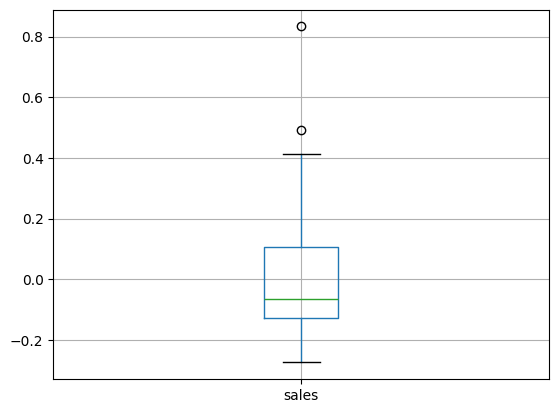

In [19]:
corr[["sales"]][:-1].boxplot()

In [21]:
import json

with open ("../data/ficzurs_koefiszietns.json", "w") as fp:
    json.dump(feature_importance_by_shapley, fp, ensure_ascii=False, indent=4)

In [22]:
y_train[:,0].shape

(2560,)

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, max_depth=3)
rf.fit(X_train, y_train[:,0])
np.sqrt(np.mean((rf.predict(X_test) - y_test) ** 2))

np.float64(121.68104819830523)

In [24]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64, 64), learning_rate_init=0.01)
mlp.fit(X_train, y_train[:,0])
np.sqrt(np.mean((mlp.predict(X_test) - y_test) ** 2))

np.float64(122.22097964017175)

In [25]:
mlp = MLPRegressor(hidden_layer_sizes=(), max_iter=1000, activation="identity", learning_rate_init=0.01)
mlp.fit(X_train, y_train[:,0])
np.sqrt(np.mean((mlp.predict(X_test) - y_test) ** 2))

np.float64(123.95392618050474)

In [26]:
mlp = MLPRegressor(hidden_layer_sizes=(32,), max_iter=1000, activation="relu", learning_rate_init=0.001)
mlp.fit(X_train, y_train[:,0])
np.sqrt(np.mean((mlp.predict(X_test) - y_test) ** 2))

np.float64(126.42897180921344)

In [37]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_x.fit(X_train, y_test)
x_train_scaled = scaler_x.transform(X_train)
x_test_scaled = scaler_x.transform(X_test)



mlp = MLPRegressor(hidden_layer_sizes=(), max_iter=10000, activation="identity", learning_rate_init=0.1)
mlp.fit(x_train_scaled, y_train[:,0])
np.sqrt(np.mean((mlp.predict(x_test_scaled) - y_test) ** 2))

np.float64(131.1400726781662)